In [1]:
!cp -r /content/drive/MyDrive/Pose_Estimation_Paper/* /content/

In [2]:
!unzip -j /content/images.zip -d /content/images/ > /dev/null

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Concatenate, Reshape
from tensorflow.keras.models import Model, load_model

In [5]:
df = pd.read_pickle('dataset.zip')
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by  ...       pk20y        px        py         pz       pqw  \
0  240.004065  ...  258.898409  0.845582 -1.128232  57.647185  0.432849   
1  316.186593  ...  323.063989 -2.419494  3.715695  52.558606 -0.100566   
2  344.785139  ...  301.092395 -2.423551  5.274911  58.307099  0.037426   
3  255.793595  ...  217.657242 -2.546036 -0.923423  54.050802  0.682806   
4  257.882250  ...  271.752007  4.864291  0.234981  52.788851  0.814325   

        pqx       pqy       pqz        dr        dq  
0 -0.312149  0.835873 -0.128532  2.533527  0.075513  
1 -0.307319  0.270371  0.906830  3.090082  0.022440  
2  0.476215  0.861147 -0.173909  1.401429  0.081497  
3  0.292231 -0.326075  0.584852  0.742336  0.093440  
4 -0.494780 -0.300450 -0.042405  1.699849  0.062826  

[5 rows x 197 columns]

In [6]:
N = len(df)
W = 256
H = 256

images = np.zeros((N, H, W, 3), dtype=np.float32)
bboxes = np.zeros((N, 4), dtype=np.float32)

In [7]:
for i in tqdm(range(N)):
  img = cv2.imread('/content/images/' + df.iloc[i]['Image'])
  img = cv2.resize(img, (W,H))
  
  images[i] = img
  bboxes[i] = df.iloc[i][['bx','by','bw','bh']].values

images /= 255.0
bboxes /= 512

100%|██████████| 1000/1000 [00:13<00:00, 74.78it/s]


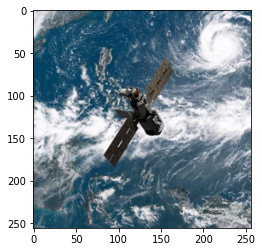

In [8]:
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 256, 256, 3) (800, 4)
(200, 256, 256, 3) (200, 4)


In [10]:
# custom diou loss function
def diou_loss_fn(y_true, y_pred):
  x_t = y_true[:,0]
  y_t = y_true[:,1]
  x_p = y_pred[:,0]
  y_p = y_pred[:,1]

  w_t = tf.maximum(y_true[:,2], 0.0)
  h_t = tf.maximum(y_true[:,3], 0.0)
  w_p = tf.maximum(y_pred[:,2], 0.0)
  h_p = tf.maximum(y_pred[:,3], 0.0)
  
  # calculate intersection area
  x_min_t = x_t - w_t/2
  y_min_t = y_t - h_t/2
  x_max_t = x_t + w_t/2
  y_max_t = y_t + h_t/2

  x_min_p = x_p - w_p/2
  y_min_p = y_p - h_p/2
  x_max_p = x_p + w_p/2
  y_max_p = y_p + h_p/2

  int_x_min = tf.maximum(x_min_t, x_min_p)
  int_y_min = tf.maximum(y_min_t, y_min_p)
  int_x_max = tf.minimum(x_max_t, x_max_p)
  int_y_max = tf.minimum(y_max_t, y_max_p)

  int_w = tf.maximum(int_x_max - int_x_min, 0.0)
  int_h = tf.maximum(int_y_max - int_y_min, 0.0)

  int_area = int_w * int_h

  # union area
  unn_area = w_t*h_t + w_p*h_p

  # # distance between bbox centers
  d = tf.square(x_t-x_p) + tf.square(y_t-y_p)

  # c = tf.square(c_x_max-c_x_min) + tf.square(c_y_max-c_y_min)
  c = tf.square(x_max_t-x_min_t) + tf.square(y_max_t-y_min_t)

  # return 1-iou+d/c
  return 1-int_area/(unn_area-int_area) + d/c

In [11]:
def build_model():
  i = Input((256,256,3))
  x = Conv2D(16, (3,3), activation='relu')(i)
  x = MaxPool2D()(x) # 128
  x = Conv2D(32, (3,3), activation='relu')(x)
  x = MaxPool2D()(x) # 64
  x = Conv2D(64, (3,3), activation='relu')(x)
  x = MaxPool2D()(x) # 32
  x = Conv2D(128, (3,3), activation='relu')(x)
  x = MaxPool2D()(x) # 16
  x = Conv2D(256, (3,3), activation='relu')(x)
  x = MaxPool2D()(x) # 8
  x = Conv2D(512, (3,3), activation='relu')(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)

  c = Dense(2)(x)
  s = Dense(2, activation='softplus')(x)

  o = Concatenate(axis=1)([c,s])

  model = Model(inputs=i, outputs=o)

  model.compile(optimizer='adam', loss=diou_loss_fn)

  return model

model = build_model()
display(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 127, 127, 16  0           ['conv2d[0][0]']                 
                                )                                                             

None

In [12]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
7/7 [==============================] - 17s 404ms/step - loss: 3.2830 - val_loss: 2.2920
Epoch 2/100
7/7 [==============================] - 1s 172ms/step - loss: 1.7909 - val_loss: 1.1099
Epoch 3/100
7/7 [==============================] - 1s 173ms/step - loss: 0.9130 - val_loss: 0.7241
Epoch 4/100
7/7 [==============================] - 1s 172ms/step - loss: 0.6909 - val_loss: 0.6398
Epoch 5/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6102 - val_loss: 0.5697
Epoch 6/100
7/7 [==============================] - 1s 173ms/step - loss: 0.5494 - val_loss: 0.5279
Epoch 7/100
7/7 [==============================] - 1s 172ms/step - loss: 0.5118 - val_loss: 0.5087
Epoch 8/100
7/7 [==============================] - 1s 173ms/step - loss: 0.5283 - val_loss: 0.5023
Epoch 9/100
7/7 [==============================] - 1s 172ms/step - loss: 0.5167 - val_loss: 0.5351
Epoch 10/100
7/7 [==============================] - 1s 171ms/step - loss: 0.4987 - val_loss: 0.5447
Epoch 11

In [23]:
with open('obj-history.txt', 'w') as f:
  f.write('loss\tval_loss\n')
  for i in range(len(history.epoch)):
    f.write(f"{history.history['loss'][i]}\t{history.history['val_loss'][i]}\n")

In [12]:
pred_bboxes_train = model.predict(X_train)
pred_bboxes_test = model.predict(X_test)

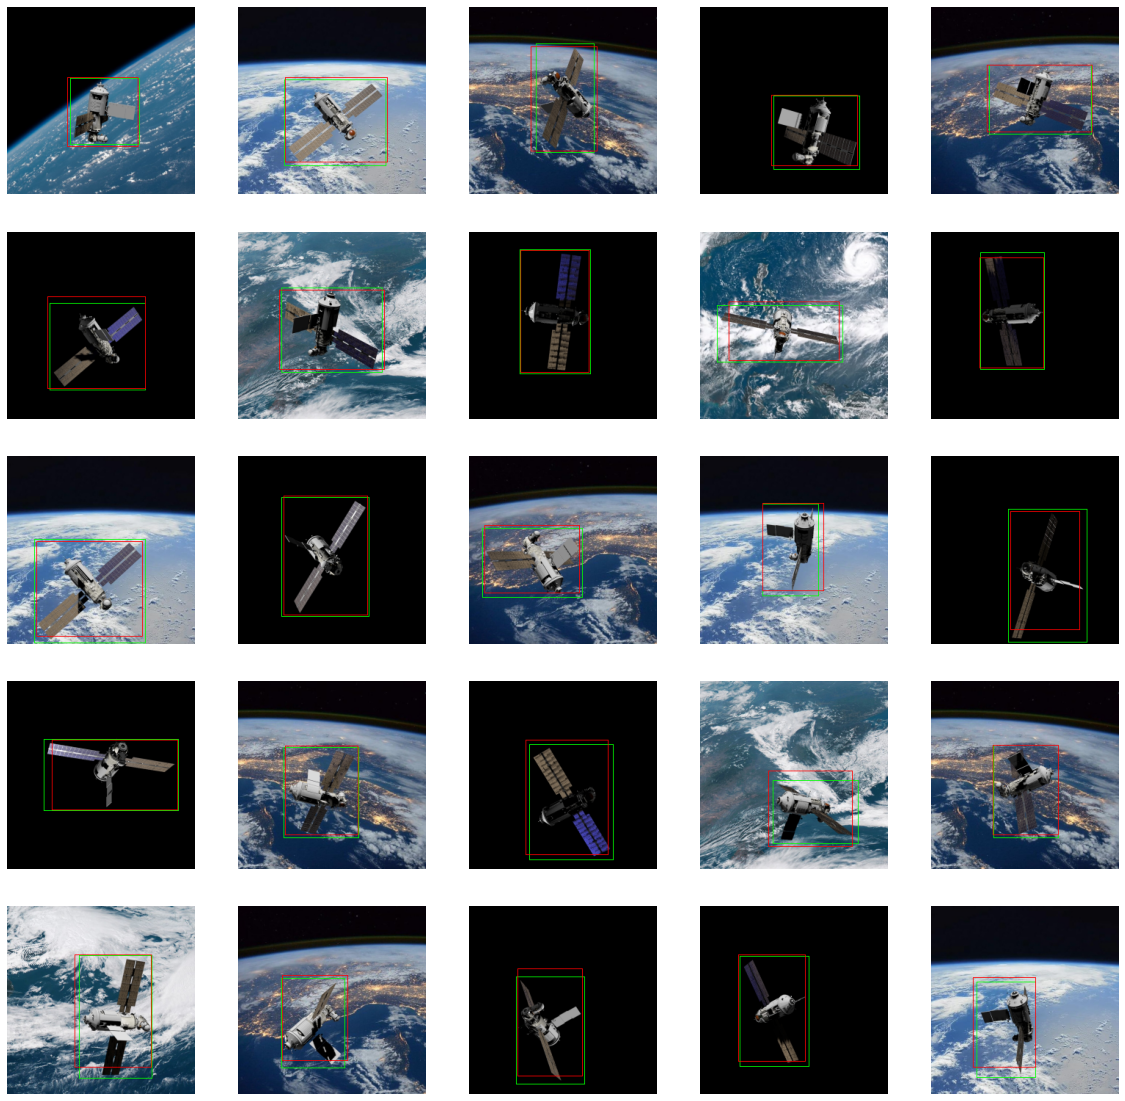

In [ ]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(X_train), 25, replace=False)):
  img = X_train[v,:,:].copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  true_bbox = y_train[v]
  pred_bbox = pred_bboxes_train[v]

  cv2.rectangle(img, (int((true_bbox[0]-true_bbox[2]/2)*256), int((true_bbox[1]-true_bbox[3]/2)*256)), (int((true_bbox[0]+true_bbox[2]/2)*256), int((true_bbox[1]+true_bbox[3]/2)*256)), (0, 1, 0), 1)
  cv2.rectangle(img, (int((pred_bbox[0]-pred_bbox[2]/2)*256), int((pred_bbox[1]-pred_bbox[3]/2)*256)), (int((pred_bbox[0]+pred_bbox[2]/2)*256), int((pred_bbox[1]+pred_bbox[3]/2)*256)), (1, 0, 0), 1)
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

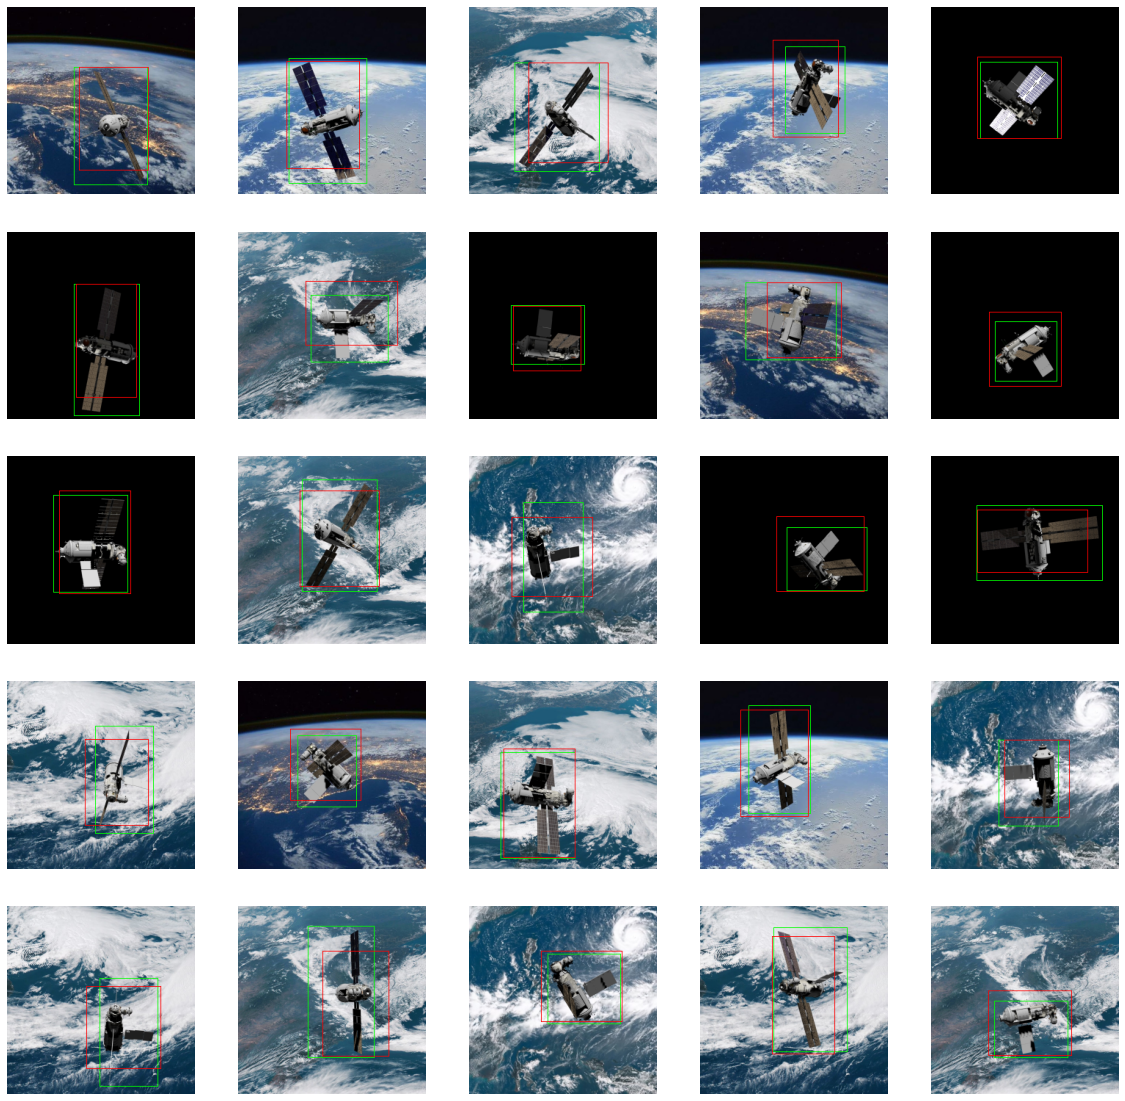

In [ ]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(X_test), 25, replace=False)):
  img = X_test[v,:,:].copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  true_bbox = y_test[v]
  pred_bbox = pred_bboxes_test[v]

  cv2.rectangle(img, (int((true_bbox[0]-true_bbox[2]/2)*256), int((true_bbox[1]-true_bbox[3]/2)*256)), (int((true_bbox[0]+true_bbox[2]/2)*256), int((true_bbox[1]+true_bbox[3]/2)*256)), (0, 1, 0), 1)
  cv2.rectangle(img, (int((pred_bbox[0]-pred_bbox[2]/2)*256), int((pred_bbox[1]-pred_bbox[3]/2)*256)), (int((pred_bbox[0]+pred_bbox[2]/2)*256), int((pred_bbox[1]+pred_bbox[3]/2)*256)), (1, 0, 0), 1)
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

In [ ]:
model.save('obj-detect-model')

In [11]:
model = load_model('obj-detect-model', custom_objects={'diou_loss_fn': diou_loss_fn})

In [30]:
pred_bboxes = model.predict(images)

df['pbx'] = pred_bboxes[:,0]*512
df['pby'] = pred_bboxes[:,1]*512
df['pbw'] = pred_bboxes[:,2]*512
df['pbh'] = pred_bboxes[:,3]*512

In [31]:
sample_loss = diou_loss_fn(bboxes, pred_bboxes).numpy()

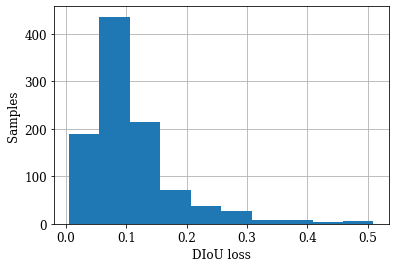

In [54]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(zorder=0)
plt.hist(sample_loss, zorder=3)
plt.xlabel('DIoU loss')
plt.ylabel('Samples')
plt.savefig('obj-detect-hist.eps', bbox_inches='tight')

In [35]:
np.where(sample_loss > 0.4)[0]

array([ 44,  60, 136, 184, 256, 318, 408, 479, 643, 749, 787, 837])

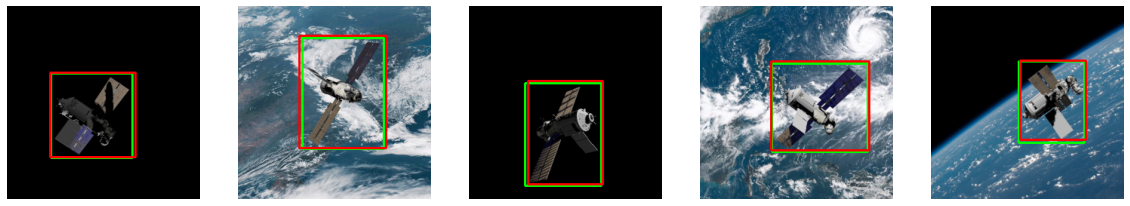

In [44]:
# plot images
fig, ax = plt.subplots(1,5, figsize=(20,4))

for i,v in enumerate(np.random.choice(np.where(sample_loss < 0.1)[0], 5, replace=False)):
  img = images[v,:,:].copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  true_bbox = bboxes[v]
  pred_bbox = pred_bboxes[v]

  cv2.rectangle(img, (int((true_bbox[0]-true_bbox[2]/2)*256), int((true_bbox[1]-true_bbox[3]/2)*256)), (int((true_bbox[0]+true_bbox[2]/2)*256), int((true_bbox[1]+true_bbox[3]/2)*256)), (0, 1, 0), 2)
  cv2.rectangle(img, (int((pred_bbox[0]-pred_bbox[2]/2)*256), int((pred_bbox[1]-pred_bbox[3]/2)*256)), (int((pred_bbox[0]+pred_bbox[2]/2)*256), int((pred_bbox[1]+pred_bbox[3]/2)*256)), (1, 0, 0), 2)
  ax[i].imshow(img)
  ax[i].axis('off')

  plt.savefig('obj-detect-good-examples.jpg', bbox_inches='tight')
  # ax[i//5][i%5].imshow(img)
  # ax[i//5][i%5].axis('off')

In [13]:
diou_loss_fn(y_train, pred_bboxes_train).numpy().mean()

0.08415644

In [14]:
diou_loss_fn(y_test, pred_bboxes_test).numpy().mean()

0.20421226

In [ ]:
df[['Image', 'bx', 'by', 'bw', 'bh','pbx', 'pby', 'pbw', 'pbh']].head()

Image          bx          by          bw          bh         pbx  \
0  img1.jpg  247.680616  240.004065  184.204553  278.976437  248.589081   
1  img2.jpg  231.409574  316.186593  192.162597  323.934479  227.977051   
2  img3.jpg  222.530529  344.785139  307.732287  218.206248  223.316528   
3  img4.jpg  222.464975  255.793595  349.354942  181.055533  225.731110   
4  img5.jpg  354.442635  257.882250  234.341452  251.664828  352.793091   

          pby         pbw         pbh  
0  234.635437  187.433929  281.510956  
1  311.201172  197.357269  323.950348  
2  341.931763  312.738037  216.947556  
3  248.589142  366.183197  185.882172  
4  250.658936  233.757797  260.979523

In [ ]:
df.to_pickle('dataset.zip')

In [ ]:
!cp -r /content/obj-detect-model /content/dataset.zip /content/drive/MyDrive/Pose_Estimation_Paper/

In [ ]:
df = pd.read_pickle('dataset.zip')

In [ ]:
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by          bw          bh         pbx         pby         pbw  \
0  240.004065  184.204553  278.976437  248.589081  234.635437  187.433929   
1  316.186593  192.162597  323.934479  227.977051  311.201172  197.357269   
2  344.785139  307.732287  218.206248  223.316528  341.931763  312.738037   
3  255.793595  349.354942  181.055533  225.731110  248.589142  366.183197   
4  257.882250  234.341452  251.664828  352.793091  250.658936  233.757797   

          pbh  
0  281.510956  
1  323.950348  
2  216.947556  
3  185.882172  
4  260.979523

In [ ]:
N = len(df)

ppb = np.zeros((N,4))

for i in range(N):
  x = df.iloc[i]['pbx']
  y = df.iloc[i]['pby']
  w = df.iloc[i]['pbw']
  h = df.iloc[i]['pbh']

  b = max(w,h)

  x = max(x, b/2)
  x = min(x, 512-b/2)
  
  y = max(y, b/2)
  y = min(y, 512-b/2)

  ppb[i,0] = x
  ppb[i,1] = y
  ppb[i,2] = b
  ppb[i,3] = b

df['ppbx'] = ppb[:,0]
df['ppby'] = ppb[:,1]
df['ppbw'] = ppb[:,2]
df['ppbh'] = ppb[:,3]

In [ ]:
df.head()

Image      x      y       z     qw     qx     qy     qz          bx  \
0  img1.jpg  0.733 -1.050  60.177  0.424 -0.329  0.838 -0.096  247.680616   
1  img2.jpg -2.675  3.939  55.630 -0.094 -0.304  0.263  0.911  231.409574   
2  img3.jpg -2.389  5.136  56.913 -0.056 -0.477 -0.852  0.209  222.530529   
3  img4.jpg -2.446 -1.007  53.320 -0.706 -0.255  0.310 -0.584  222.464975   
4  img5.jpg  4.701  0.091  51.103  0.798 -0.505 -0.325 -0.046  354.442635   

           by          bw          bh         pbx         pby         pbw  \
0  240.004065  184.204553  278.976437  248.589081  234.635437  187.433929   
1  316.186593  192.162597  323.934479  227.977051  311.201172  197.357269   
2  344.785139  307.732287  218.206248  223.316528  341.931763  312.738037   
3  255.793595  349.354942  181.055533  225.731110  248.589142  366.183197   
4  257.882250  234.341452  251.664828  352.793091  250.658936  233.757797   

          pbh        ppbx        ppby        ppbw        ppbh  
0  281.510956  248.589081  234.635437  281.510956  281.510956  
1  323.950348  227.977051  311.201172  323.950348  323.950348  
2  216.947556  223.316528  341.931763  312.738037  312.738037  
3  185.882172  225.731110  248.589142  366.183197  366.183197  
4  260.979523  352.793091  250.658936  260.979523  260.979523

In [ ]:
!mkdir /content/images2

mkdir: cannot create directory ‘/content/images2’: File exists


In [ ]:
for i in tqdm(range(N)):
  img = cv2.imread('/content/images/' + df.iloc[i]['Image'])
  ppbox = df.iloc[i][['ppbx','ppby','ppbw','ppbh']].values
  
  x_min = int(ppbox[0] - ppbox[2]/2)
  y_min = int(ppbox[1] - ppbox[3]/2)
  x_max = int(ppbox[0] + ppbox[2]/2)
  y_max = int(ppbox[1] + ppbox[3]/2)
  
  cropped_img = img[y_min:y_max, x_min:x_max]
  cropped_img = cv2.resize(cropped_img, (512,512))
  
  cv2.imwrite('/content/images2/'+df.iloc[i]['Image'], cropped_img)

100%|██████████| 1000/1000 [00:11<00:00, 84.40it/s]


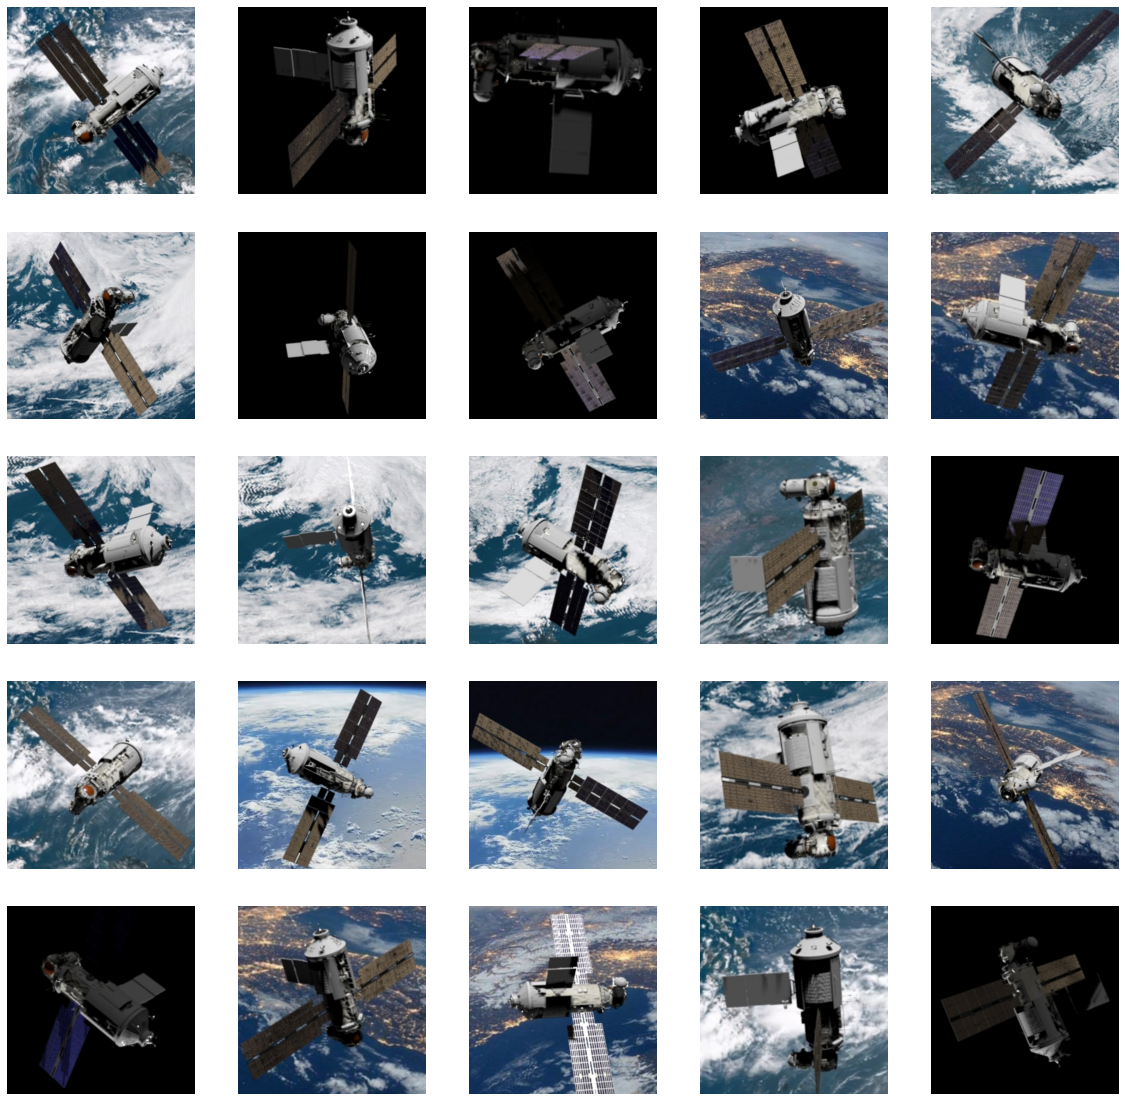

In [ ]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(df), 25, replace=False)):
  img = cv2.imread('/content/images2/'+df.iloc[v]['Image'])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

In [ ]:
!zip images2.zip /content/images2/*

updating: content/images2/img1000.jpg (deflated 20%)
updating: content/images2/img100.jpg (deflated 0%)
updating: content/images2/img101.jpg (deflated 0%)
updating: content/images2/img102.jpg (deflated 0%)
updating: content/images2/img103.jpg (deflated 0%)
updating: content/images2/img104.jpg (deflated 0%)
updating: content/images2/img105.jpg (deflated 0%)
updating: content/images2/img106.jpg (deflated 0%)
updating: content/images2/img107.jpg (deflated 0%)
updating: content/images2/img108.jpg (deflated 0%)
updating: content/images2/img109.jpg (deflated 0%)
updating: content/images2/img10.jpg (deflated 0%)
updating: content/images2/img110.jpg (deflated 0%)
updating: content/images2/img111.jpg (deflated 0%)
updating: content/images2/img112.jpg (deflated 0%)
updating: content/images2/img113.jpg (deflated 0%)
updating: content/images2/img114.jpg (deflated 0%)
updating: content/images2/img115.jpg (deflated 0%)
updating: content/images2/img116.jpg (deflated 0%)
updating: content/images2/img1

In [ ]:
!cp -r /content/images2.zip /content/drive/MyDrive/Pose_Estimation_Paper/